In [1]:
from sklearn.datasets import make_circles
#number of samples
n_samples = 1000
#create circles
X,y = make_circles(n_samples,noise=0.03,random_state = 42)

In [2]:
len(X),len(y)

(1000, 1000)

In [3]:
print(f"first first sample of x : {X[:5]}"),print(f"first first sample of x : {y[:5]}")

first first sample of x : [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first first sample of x : [1 1 1 1 0]


(None, None)

In [4]:
#make dataframe
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2":X[:,1],
                        "label":y})

In [5]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


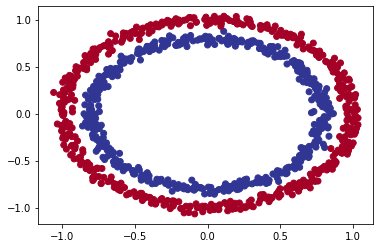

In [6]:
#Visualize data
import matplotlib.pyplot as plt 
plt.scatter(x = X[:,0],y=X[:,1],c=y,cmap =plt.cm.RdYlBu)
plt.show()

In [7]:
#check inputs and output and output shapes 
X.shape,y.shape

((1000, 2), (1000,))

In [8]:
#View the first exmaple of feature of feature and labels
x_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X : {x_sample} and the same for y : {y_sample}")

Values for one sample of X : [0.75424625 0.23148074] and the same for y : 1


Turning data into tensors

In [9]:
import torch

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [11]:
type(X),type(y)

(torch.Tensor, torch.Tensor)

In [12]:
torch.manual_seed(42)

In [13]:
#Split data into trainng and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X,y,random_state=0,test_size=0.2)

In [14]:
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

Building a model

- Set up device ahnostic code
- Construct a model
- Define loss function and optimizer
- Create training and test loop


In [15]:
#Set up device agnostic code
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [16]:
#Constructing a model
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    #Define nn.linear to handle shape of data
    self.layer_1 = nn.Linear(in_features=2,out_features = 5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)


  def forward(self,x):
    return self.layer_2(self.layer_1(x)) # from x to layer 1 from layer 1 to layer 2

model_0 = CircleModelV1().to(device)
model_0

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
next(model_0.parameters()).device

device(type='cpu')

In [18]:
#Replicate the above code in a simpler way
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
     nn.Linear(in_features=5,out_features=1)
    
).to(device)

In [19]:
#OR
#Constructing a model
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    #Define nn.linear to handle shape of data
    self.two_layer_network = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
     nn.Linear(in_features=5,out_features=1)
    
)

  def forward(self,x):
    return self.two_layer_network # from x to layer 1 from layer 1 to layer 2

model_0 = CircleModelV1().to(device)
model_0

CircleModelV1(
  (two_layer_network): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [20]:
#Replicate the above code in a simpler way
torch.manual_seed(42)
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
     nn.Linear(in_features=5,out_features=1)
    
).to(device)

In [21]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('0.bias', tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('1.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('1.bias', tensor([-0.2060]))])

In [22]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Lenght of predictions  :{len(untrained_preds)},shape :{untrained_preds.shape}")
print(f"Lenght of test samples : {len(X_test)},Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 lables:\n{y_test[:10]}")

Lenght of predictions  :200,shape :torch.Size([200, 1])
Lenght of test samples : 200,Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]])

First 10 lables:
tensor([1., 1., 0., 0., 1., 0., 1., 1., 0., 0.])


In [23]:
## Set up loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [24]:
#Calculate accuracy
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [25]:
#Training loop

In [26]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [27]:
#view first 5 ouptuts of the forward pass on test data
model_0.eval()
with torch.inference_mode():
        y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1480],
        [-0.1918],
        [-0.1025],
        [-0.0834],
        [-0.1910]])

In [28]:
y_test[:5]

tensor([1., 1., 0., 0., 1.])

In [29]:
#Use sigmoid to transform logist
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.4631],
        [0.4522],
        [0.4744],
        [0.4792],
        [0.4524]])

In [30]:
torch.round(y_preds_probs)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

Training and test loop

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#set number of epochs
epochs = 1000
#pu data to devivce
X_train , X_test,y_train,y_test = X_train.to(device),X_test.to(device),y_train.to(device),y_test.to(device)

for epoch in range(epochs):
  model_0.train()
  #forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits to probs and lables
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred = y_pred)

  #optimizer zero grad
  optimizer.zero_grad()
  loss.backward()
  #optimizer step
  optimizer.step()
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #Test loss and accuracy
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true = y_test,y_pred = test_pred)
  #print whats happening

  if epoch & 10 == 0:
    print(f"Epoch {epoch} | Loss:{loss:.5f}, Acc {acc:.2f} | Test loss: {test_loss:.5f}, Test acc:{test_acc:.2f}")
  

Epoch 0 | Loss:0.69894, Acc 48.00 | Test loss: 0.68492, Test acc:58.00
Epoch 1 | Loss:0.69836, Acc 48.00 | Test loss: 0.68545, Test acc:58.00
Epoch 4 | Loss:0.69692, Acc 48.00 | Test loss: 0.68703, Test acc:58.00
Epoch 5 | Loss:0.69653, Acc 48.00 | Test loss: 0.68754, Test acc:58.00
Epoch 16 | Loss:0.69404, Acc 48.62 | Test loss: 0.69243, Test acc:51.00
Epoch 17 | Loss:0.69392, Acc 49.12 | Test loss: 0.69280, Test acc:50.00
Epoch 20 | Loss:0.69362, Acc 49.62 | Test loss: 0.69382, Test acc:49.00
Epoch 21 | Loss:0.69353, Acc 50.38 | Test loss: 0.69414, Test acc:49.00
Epoch 32 | Loss:0.69296, Acc 51.75 | Test loss: 0.69688, Test acc:51.50
Epoch 33 | Loss:0.69293, Acc 51.38 | Test loss: 0.69707, Test acc:50.50
Epoch 36 | Loss:0.69285, Acc 52.12 | Test loss: 0.69760, Test acc:49.50
Epoch 37 | Loss:0.69283, Acc 51.88 | Test loss: 0.69776, Test acc:49.00
Epoch 48 | Loss:0.69265, Acc 54.00 | Test loss: 0.69914, Test acc:48.00
Epoch 49 | Loss:0.69263, Acc 54.12 | Test loss: 0.69923, Test acc:48

In [33]:
#Making some predictions and visual
import requests
from pathlib import Path
root = "/content"
if Path("helper_fucntions.py").is_file():
  print("Already exists")
else:
  print("Download helper functions")
  path_ = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
  request = requests.get(path_)
  with open("helper_functions.py","wb") as f:
    f.write(request.content)



Download helper functions


In [34]:
import helper_functions
from helper_functions import plot_predictions,plot_decision_boundary

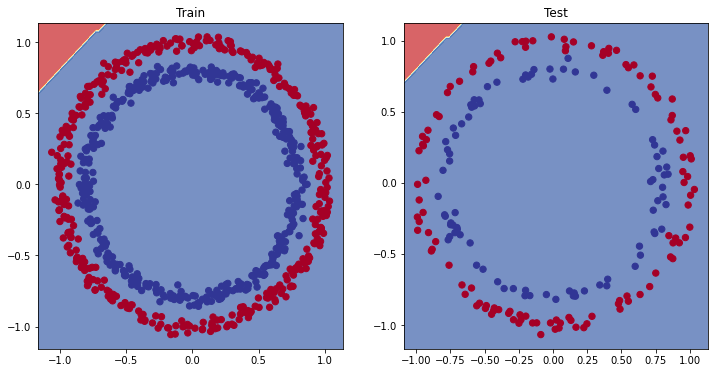

In [35]:
#plot decision boundary of model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)


Improving model performance
- Add more layers
- Adding more hidden units
- Fit for longer
- Changing the activation function
- Changing learning rate
- Changing loss function

All these are from model perspective not from data perspective

In [36]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[ 0.5461,  0.5932],
                      [-0.1958,  0.6075],
                      [-0.1673,  0.1270],
                      [-0.3237,  0.4430],
                      [ 0.6068, -0.5403]])),
             ('0.bias', tensor([0.6076, 0.1851, 0.5388, 0.0626, 0.3645])),
             ('1.weight',
              tensor([[-0.0943,  0.3059,  0.1468, -0.2200,  0.1791]])),
             ('1.bias', tensor([-0.0494]))])

In [37]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
     nn.Linear(in_features=5,out_features=1)
    
).to(device)

In [38]:
class CircleModelv2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features = 1)

  def forward(self,x):
    '''
    z = self.layer_1(x)
    z = self.layer__2(z)
    z = self.layer_3(z)
    return z '''
    return self.layer_3(self.layer_2(self.layer_1(x)))

  
model_1 = CircleModelv2().to(device)
model_1


CircleModelv2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [39]:
model_1.state_dict()

OrderedDict([('layer_1.weight', tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386],
                      [-0.6007,  0.5459],
                      [ 0.1177, -0.2296],
                      [ 0.4370,  0.1102],
                      [ 0.5713,  0.0773],
                      [-0.2230,  0.1900]])),
             ('layer_1.bias',
              tensor([-0.1918,  0.2976,  0.6313,  0.4087, -0.3091,  0.4082,  0.1265,  0.3591,
                      -0.4310, -0.7000])),
             ('layer_2.weight',
              tensor([[-0.1222, -0.2426,  0.2595,  0.0911,  0.1310,  0.1000, -0.0055,  0.2475,
                       -0.2247,  0.0199],
                      [-0.2158,  0.0975, -0.1089,  0.0969, -0.0659,  0.2623, -0.1874, -0.1886,
                       -0.1886,  0.2844],
                      [ 0.1054,  0.3043, -0.2610, -0.3137, -0.2474, -0.2127,  0.1281, 

In [40]:
## Set up loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [41]:
#Traning and evaluation loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#pu data to devivce
X_train , X_test,y_train,y_test = X_train.to(device),X_test.to(device),y_train.to(device),y_test.to(device)
epochs = 1000
for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #loss and accuracy
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)

  #optimizer zero grad
  optimizer.zero_grad()

  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

  #Calculate loss
  test_loss = loss_fn(test_logits,y_test)
  test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss:{test_loss:.5f}, Test acc:{test_acc:.2f}")

Epoch: 0 | Loss: 0.70038, Acc: 52.12 | Test loss:0.70100, Test acc:50.50
Epoch: 100 | Loss: 0.70038, Acc: 52.12 | Test loss:0.70100, Test acc:50.50
Epoch: 200 | Loss: 0.70038, Acc: 52.12 | Test loss:0.70100, Test acc:50.50
Epoch: 300 | Loss: 0.70038, Acc: 52.12 | Test loss:0.70100, Test acc:50.50
Epoch: 400 | Loss: 0.70038, Acc: 52.12 | Test loss:0.70100, Test acc:50.50
Epoch: 500 | Loss: 0.70038, Acc: 52.12 | Test loss:0.70100, Test acc:50.50
Epoch: 600 | Loss: 0.70038, Acc: 52.12 | Test loss:0.70100, Test acc:50.50
Epoch: 700 | Loss: 0.70038, Acc: 52.12 | Test loss:0.70100, Test acc:50.50
Epoch: 800 | Loss: 0.70038, Acc: 52.12 | Test loss:0.70100, Test acc:50.50
Epoch: 900 | Loss: 0.70038, Acc: 52.12 | Test loss:0.70100, Test acc:50.50


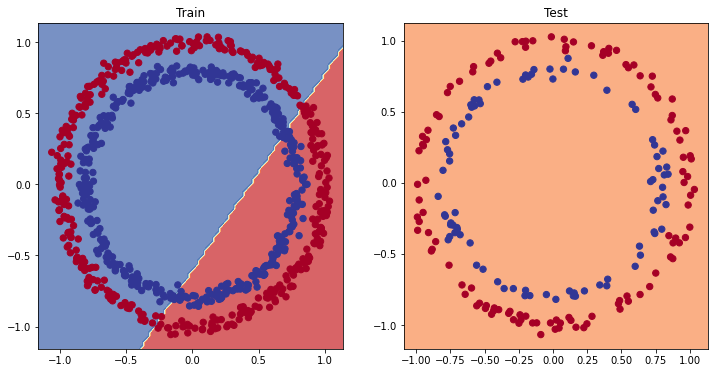

In [43]:
#plot decision boundary of model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)


Preparing data in model can we fit straight line -- Troubleshooting

In [44]:
#Creating some data 
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

#Create data
x_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * x_regression + bias
x_regression[:5], y_regression[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [45]:
train_split = int(0.8 * len(x_regression))
x_train_reg , y_train_reg = x_regression[:train_split],y_regression[:train_split]
x_test_reg , y_test_reg = x_regression[train_split:],y_regression[train_split:]

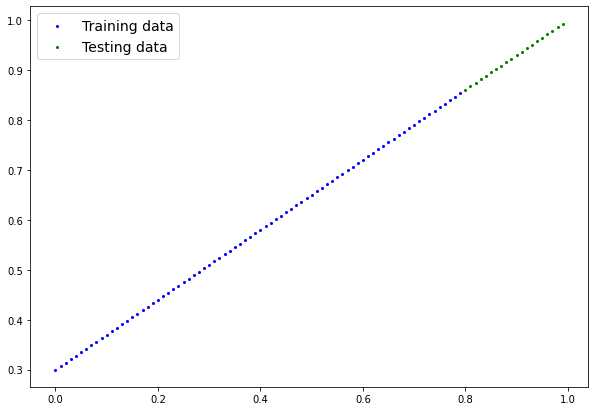

In [47]:
plot_predictions(train_data=x_train_reg,train_labels=y_train_reg,test_data=x_test_reg,test_labels=y_test_reg)

In [48]:
model_1

CircleModelv2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [51]:
# Adjusying model 1 to fit straight line
#same architecure but usiing nn.sequential
model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)).to(device)

In [55]:
#loss and optimizer 
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),lr=0.01)

In [56]:
#Train model
torch.manual_seed(43)
torch.cuda.manual_seed(42)

epochs = 1000
#put data on target device
x_train_reg,y_train_reg = x_train_reg.to(device), y_train_reg.to(device)
x_test_reg, y_test_reg = x_test_reg.to(device),y_test_reg.to(device)

for epoch in range(epochs):
  y_pred = model_2(x_train_reg)
  loss = loss_fn(y_pred,y_train_reg)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(x_test_reg)
    test_loss = loss_fn(test_pred,y_test_reg)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.05941 Test loss: 0.00576
Epoch: 100 | Loss: 0.00833 Test loss: 0.00739
Epoch: 200 | Loss: 0.00585 Test loss: 0.01384
Epoch: 300 | Loss: 0.00616 Test loss: 0.01354
Epoch: 400 | Loss: 0.00587 Test loss: 0.01384
Epoch: 500 | Loss: 0.00618 Test loss: 0.01353
Epoch: 600 | Loss: 0.00589 Test loss: 0.01382
Epoch: 700 | Loss: 0.00620 Test loss: 0.01349
Epoch: 800 | Loss: 0.00591 Test loss: 0.01377
Epoch: 900 | Loss: 0.00622 Test loss: 0.01343


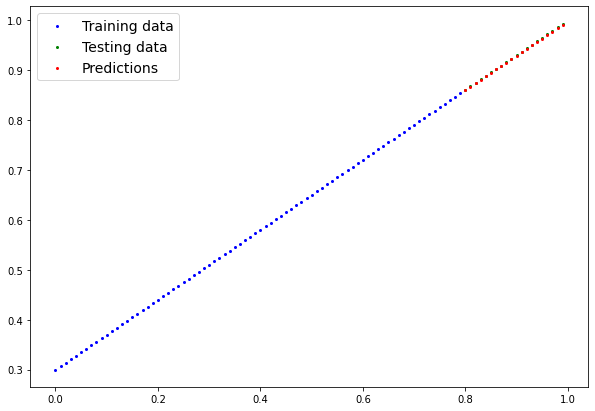

In [58]:
#evaluation model
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(x_test_reg)

#plot predictions
plot_predictions(train_data=x_train_reg.cpu(),train_labels=y_train_reg.cpu(),test_data=x_test_reg.cpu(),test_labels=y_test_reg.cpu(),predictions = y_preds.cpu())

The missing piece of our model non-linearity - What patter can do draw if you are given infinite amount of straigght and non - straight lines


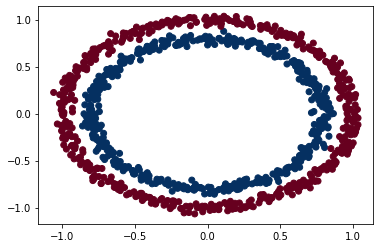

In [73]:
#Combining linear and non-linearity
#make and plot data
from sklearn.datasets import make_circles
n_samples = 1000

X,y = make_circles(n_samples,noise=0.03,random_state=42)
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdBu)
plt.show()

In [74]:
#Convert data to tensors and then to train and test)split
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
x_train, x_test, y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)
X_train[:5],y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

In [76]:
#Buidling model with non-linearity
from torch import nn
class CircleModelv2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()
    
  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelv2().to(device)

In [69]:
model_3.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.6745,  0.1025],
                      [-0.2030,  0.5020],
                      [-0.0832, -0.2596],
                      [-0.6280,  0.4758],
                      [-0.1705, -0.4540],
                      [-0.4927, -0.5026],
                      [ 0.2160,  0.2358],
                      [ 0.1283, -0.4424],
                      [-0.6423, -0.4050],
                      [-0.4654,  0.1474]])),
             ('layer_1.bias',
              tensor([ 0.2603, -0.2652, -0.6460,  0.4580,  0.3009, -0.2810, -0.2616, -0.0183,
                      -0.3060,  0.3768])),
             ('layer_2.weight',
              tensor([[ 0.0558, -0.1885, -0.2629, -0.1228, -0.2524, -0.0600, -0.0655, -0.1350,
                        0.0419, -0.1406],
                      [ 0.1797,  0.1836, -0.0834, -0.1316, -0.2940, -0.0076, -0.2524,  0.2757,
                        0.1588, -0.0264],
                      [-0.0321, -0.0202,  0.2923, -0.0352,  0.0570,  0.1750,  0.1546, 

In [77]:
#optimizer and loss function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),lr=0.1)

In [84]:
#Traning model with non-linearity
torch.manual_seed(42)
torch.cuda.manual_seed(42)

x_train,y_train = x_train.to(device),y_train.to(device)
x_test,y_test = x_test.to(device),y_test.to(device)

epochs = 1000
for epoch in range(epochs):
  model_3.train()

  #forward pass
  y_logits = model_3(x_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #Calculate the loss
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

  if epoch % 100 == 0:
    
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss:{test_loss:.5f}, Test acc:{test_acc:.2f}")


Epoch: 0 | Loss: 0.01623, Acc: 99.88 | Test loss:0.03294, Test acc:100.00
Epoch: 100 | Loss: 0.01534, Acc: 100.00 | Test loss:0.03172, Test acc:100.00
Epoch: 200 | Loss: 0.01454, Acc: 100.00 | Test loss:0.03064, Test acc:100.00
Epoch: 300 | Loss: 0.01382, Acc: 100.00 | Test loss:0.02970, Test acc:99.50
Epoch: 400 | Loss: 0.01317, Acc: 100.00 | Test loss:0.02884, Test acc:99.50
Epoch: 500 | Loss: 0.01258, Acc: 100.00 | Test loss:0.02793, Test acc:99.50
Epoch: 600 | Loss: 0.01204, Acc: 100.00 | Test loss:0.02706, Test acc:99.50
Epoch: 700 | Loss: 0.01155, Acc: 100.00 | Test loss:0.02626, Test acc:99.50
Epoch: 800 | Loss: 0.01110, Acc: 100.00 | Test loss:0.02552, Test acc:99.50
Epoch: 900 | Loss: 0.01068, Acc: 100.00 | Test loss:0.02483, Test acc:99.50


In [89]:
#Evaluating mmodel trained with non linear functions
model_3.eval()
with torch.inference_mode():
    test_logits = model_3(x_test).squeeze()
    y_preds = torch.round(torch.sigmoid(test_logits))
y_preds[:10],y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

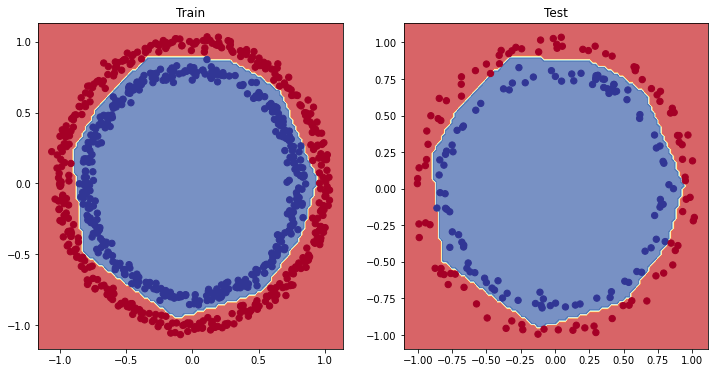

In [91]:
#plot decision boundary of model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)

Replicating non-linear activation functions

In [93]:
#create tensor
A = torch.arange(-10,10,0.1)
A.dtype

torch.float32

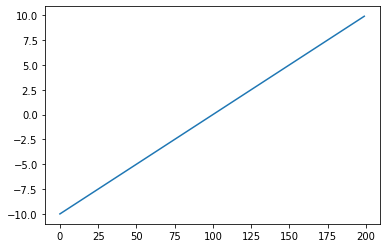

In [94]:
plt.plot(A)

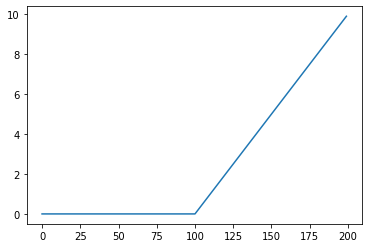

In [95]:
plt.plot(torch.relu(A))

In [96]:
#Create relu
def relu(x:torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0),x)
relu(A)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000,
        0.8000, 0.9000, 1.0000, 1.1000, 

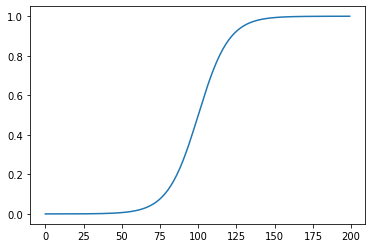

In [98]:
#Experimenting sigmoid
def sigmoid(x):
   return 1/ (1 + torch.exp(-x))
plt.plot(sigmoid(A))
plt.show()

Multiclass classification problem

Creating a toy - multi class datasets

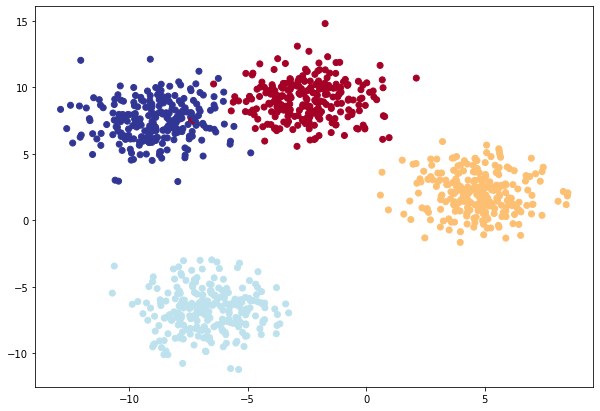

In [125]:
from sklearn.datasets import make_blobs 
#set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
x_blob, y_blob = make_blobs(n_samples=1000,n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

#Turn data into tensors
x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

#split into traning and test data
x_b_train,x_b_test,y_b_train,y_b_test = train_test_split(x_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(x_blob[:,0],x_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu);
plt.show()

Building a multiclass classification model

In [101]:
#create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [138]:
#Building a mutlticlass classification
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x):
      return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,output_features=4).to(device)

In [117]:
model_4.state_dict()

OrderedDict([('linear_layer_stack.0.weight', tensor([[-0.5740,  0.0765],
                      [ 0.2095, -0.3265],
                      [-0.1978,  0.4776],
                      [ 0.0563,  0.0319],
                      [-0.1740, -0.6403],
                      [-0.6649, -0.3380],
                      [-0.3594,  0.2203],
                      [-0.2058, -0.2766]])),
             ('linear_layer_stack.0.bias',
              tensor([ 0.6742,  0.2463,  0.5041, -0.3423, -0.2888,  0.2599, -0.4711, -0.4622])),
             ('linear_layer_stack.2.weight',
              tensor([[-0.0171, -0.1293, -0.2650,  0.2097,  0.2843,  0.0574, -0.0616, -0.3275],
                      [-0.1288,  0.0900,  0.1667, -0.0447, -0.1398,  0.1970, -0.2816,  0.2235],
                      [-0.1372,  0.0054, -0.0699,  0.0429, -0.1068,  0.2571, -0.0092,  0.2760],
                      [ 0.3399, -0.1722, -0.2579,  0.2837,  0.2770, -0.2700, -0.0273, -0.3486],
                      [-0.2894,  0.0683,  0.0941,  0.0749, -0

In [139]:
#loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(),lr=0.1)

In [124]:
y_b_train

tensor([1., 0., 2., 2., 0., 0., 0., 1., 3., 0., 0., 0., 3., 2., 3., 2., 1., 1.,
        3., 2., 2., 2., 3., 1., 3., 2., 3., 0., 1., 0., 0., 1., 1., 3., 0., 2.,
        2., 1., 1., 3., 1., 1., 2., 3., 3., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
        1., 1., 0., 0., 2., 2., 3., 1., 0., 2., 1., 3., 2., 2., 2., 1., 0., 2.,
        3., 1., 1., 1., 2., 0., 0., 1., 2., 3., 1., 3., 3., 2., 3., 3., 2., 2.,
        1., 0., 0., 1., 2., 1., 3., 1., 2., 1., 3., 3., 3., 0., 2., 1., 2., 3.,
        1., 1., 2., 0., 3., 3., 2., 0., 2., 0., 3., 2., 0., 0., 2., 2., 0., 1.,
        2., 0., 3., 3., 2., 3., 2., 1., 3., 1., 1., 1., 1., 0., 0., 1., 0., 2.,
        3., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 2., 2., 0., 0., 3., 0., 3.,
        3., 3., 0., 2., 0., 1., 2., 2., 2., 3., 0., 1., 1., 0., 1., 2., 0., 3.,
        2., 1., 3., 2., 3., 0., 3., 1., 1., 2., 2., 2., 2., 2., 2., 0., 3., 3.,
        2., 1., 1., 2., 3., 1., 0., 0., 1., 3., 0., 1., 3., 3., 2., 3., 3., 3.,
        1., 0., 0., 1., 0., 3., 2., 1., 

Training and testing loop

In [140]:
#put data on device
torch.manual_seed(42)
torch.cuda.manual_seed(42)
x_b_train,x_b_test,y_b_train,y_b_test = x_b_train.to(device),x_b_test.to(device),y_b_train.to(device),y_b_test.to(device)
for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(x_b_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
  loss = loss_fn(y_logits,y_b_train)
  acc = accuracy_fn(y_true=y_b_train,
                    y_pred=y_pred)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  ## Testing mode
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(x_b_test)
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits,y_b_test)
    test_acc = accuracy_fn(y_true=y_b_test,
                           y_pred=test_preds)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss:{test_loss:.5f}, Test acc:{test_acc:.2f}")

  

Epoch: 0 | Loss: 1.04324, Acc: 65.50 | Test loss:0.57861, Test acc:95.50
Epoch: 10 | Loss: 0.14398, Acc: 99.12 | Test loss:0.13037, Test acc:99.00
Epoch: 20 | Loss: 0.08062, Acc: 99.12 | Test loss:0.07216, Test acc:99.50
Epoch: 30 | Loss: 0.05924, Acc: 99.12 | Test loss:0.05133, Test acc:99.50
Epoch: 40 | Loss: 0.04892, Acc: 99.00 | Test loss:0.04098, Test acc:99.50
Epoch: 50 | Loss: 0.04295, Acc: 99.00 | Test loss:0.03486, Test acc:99.50
Epoch: 60 | Loss: 0.03910, Acc: 99.00 | Test loss:0.03083, Test acc:99.50
Epoch: 70 | Loss: 0.03643, Acc: 99.00 | Test loss:0.02799, Test acc:99.50
Epoch: 80 | Loss: 0.03448, Acc: 99.00 | Test loss:0.02587, Test acc:99.50
Epoch: 90 | Loss: 0.03300, Acc: 99.12 | Test loss:0.02423, Test acc:99.50
Epoch: 100 | Loss: 0.03185, Acc: 99.12 | Test loss:0.02293, Test acc:99.50
Epoch: 110 | Loss: 0.03093, Acc: 99.12 | Test loss:0.02186, Test acc:99.50
Epoch: 120 | Loss: 0.03017, Acc: 99.12 | Test loss:0.02097, Test acc:99.50
Epoch: 130 | Loss: 0.02955, Acc: 99.

In [141]:
#Making and evaluating model
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(x_b_test)

y_logits[:10]

tensor([[  6.1117,  18.9106, -22.9633, -14.6996],
        [  9.5663, -23.8503,   5.8413,  17.7027],
        [ -8.4024, -21.8531,  30.5468,  17.0858],
        [  2.1340,  14.6655, -13.7829, -11.2653],
        [ 13.2141,   3.9343, -21.4953,  -3.6479],
        [ 10.8393, -29.6209,   8.5482,  22.0347],
        [ -9.3843, -15.7081,  27.1176,  12.4539],
        [ 11.9276,  -3.3287, -13.8623,   1.9500],
        [ -7.8685, -31.8188,  37.6566,  24.6510],
        [ 12.1832,  -0.6223, -16.3793,  -0.1247]])

In [133]:
y_preds_labels = torch.softmax(y_logits,dim=1).argmax(dim=1)

In [134]:
y_preds_labels

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [135]:
y_b_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

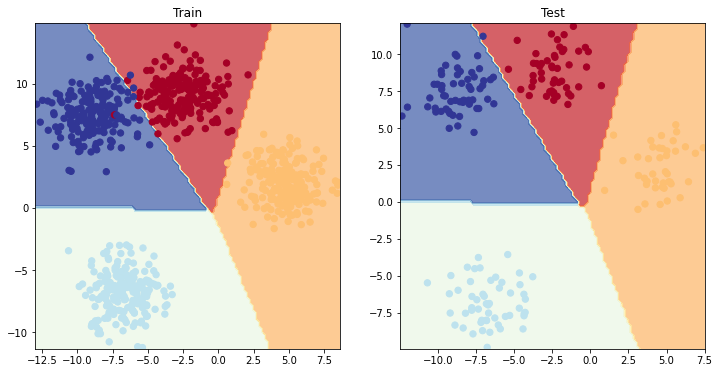

In [142]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,x_b_train, y_b_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,x_b_test,y_b_test)

Few more classification metrics
* Accuracy
* Precision
* Recall
* F1_Score
* AUC_ROC
* Classification report 
* Confusion matrix

In [143]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 13.9 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy

#set up metrics

acc = Accuracy().to(device)
acc_ = acc()